**Image Classification with Tensorflow and CNN**

Installing LR Finder and TFDS

In [ ]:
!pip install tensorflow-hub
!pip install tensorflow-datasets
!git clone https://github.com/beringresearch/lrfinder/
!cd lrfinder && python3 -m pip install .

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
from lrfinder import LRFinder
K = tf.keras.backend
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, Input, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.models import Model
import numpy as np
import platform
import datetime
import os
import math
import random

Downloading Rock Paper Scissors

In [3]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

Image Preprocessing function

In [4]:
def preprocess_img(image, label):
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [256,256])
    return image, label

dataset_train = dataset_train_raw.map(preprocess_img)
dataset_test = dataset_test_raw.map(preprocess_img)

In [5]:
print(dataset_train.cardinality().numpy())
print(dataset_test.cardinality().numpy())

2520
372


In [6]:
dataset_train = dataset_train.batch(64)
dataset_test = dataset_test.batch(32)

Model Architecture

In [20]:
input_layer = Input(shape=(256,256,3))
conv_1 = Conv2D(16, (5,5), activation='relu', input_shape=(256, 256, 3))
conv_2 = Conv2D(32, (5,5), activation='relu')
conv_3 = Conv2D(64, (5,5), strides=2, activation='relu')
conv_4 = Conv2D(128, (5,5), strides=2, activation='relu')

x = conv_1(input_layer)
x = MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = conv_2(x)
x = MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = conv_3(x)
x = MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = conv_4(x)
x = MaxPooling2D(pool_size=[2, 2], strides=2)(x)

x = Flatten()(x)
x = Dense(512, activation ='relu')(x)

x = Dropout(0.5)(x) 
x = Dense(256, activation ='relu')(x)

x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(3, activation ='softmax')(x)

model = Model(input_layer, x)


Compiling Model

In [21]:
model.compile(optimizer ='Adam', 
              loss ="sparse_categorical_crossentropy", 
              metrics =["sparse_categorical_accuracy"]) 


LR Finder to find best Learning Rate

In [22]:
BATCH = 64

STEPS_PER_EPOCH = np.ceil(2520 / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(dataset_train, start_lr=1e-6, end_lr=1, epochs=10,
               steps_per_epoch=STEPS_PER_EPOCH)
               
learning_rates = lr_finder.get_learning_rates()
losses = lr_finder.get_losses()


Epoch 1/10
40/40 [==============================] - 199s 5s/step - loss: 1.7092 - sparse_categorical_accuracy: 0.3163
Epoch 2/10
40/40 [==============================] - 198s 5s/step - loss: 1.5649 - sparse_categorical_accuracy: 0.3496
Epoch 3/10
40/40 [==============================] - 198s 5s/step - loss: 1.2601 - sparse_categorical_accuracy: 0.4119
Epoch 4/10
40/40 [==============================] - 198s 5s/step - loss: 0.7785 - sparse_categorical_accuracy: 0.6508
Epoch 5/10
40/40 [==============================] - 198s 5s/step - loss: 0.2157 - sparse_categorical_accuracy: 0.9242
Epoch 6/10
40/40 [==============================] - 198s 5s/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9810
Epoch 7/10
40/40 [==============================] - 35s 769ms/step - loss: 0.2424 - sparse_categorical_accuracy: 0.9152


Assigning the Best value through Backend

In [23]:
best_lr = lr_finder.get_best_lr(sma=20)
K.set_value(model.optimizer.lr, best_lr)

Plotting LR Finder Observations for analysis

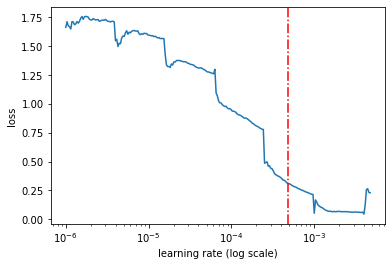

In [24]:
import matplotlib.pyplot as plt

def plot_loss(learning_rates, losses, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[:-1],
            losses[:-1])
    ax.set_xscale(x_scale)
    return(ax)

axs = plot_loss(learning_rates, losses)
axs.axvline(x=lr_finder.get_best_lr(sma=20), c='r', linestyle='-.')

In [25]:
model.summary() 


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 16)      1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 32)      12832     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0   

Defining Early Stop Callback

In [26]:
earlystop_callback = EarlyStopping(
  monitor='val_loss', min_delta=0.0001, patience=2)

Fitting Model with Datasets and callback

In [27]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_test, callbacks=[earlystop_callback])

Epoch 1/10
40/40 [==============================] - 206s 5s/step - loss: 0.9014 - sparse_categorical_accuracy: 0.6091 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.7688
Epoch 2/10
40/40 [==============================] - 205s 5s/step - loss: 0.0981 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.7937 - val_sparse_categorical_accuracy: 0.9140
Epoch 3/10
40/40 [==============================] - 206s 5s/step - loss: 0.0180 - sparse_categorical_accuracy: 0.9956 - val_loss: 0.6989 - val_sparse_categorical_accuracy: 0.8978
Epoch 4/10
40/40 [==============================] - 205s 5s/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.5840 - val_sparse_categorical_accuracy: 0.9032
Epoch 5/10
40/40 [==============================] - 206s 5s/step - loss: 0.0031 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.4979 - val_sparse_categorical_accuracy: 0.9247
Epoch 6/10
40/40 [==============================] - 206s 5s/step - loss: 0.0018 - sparse_categorical_accu

Plotting Model Performance

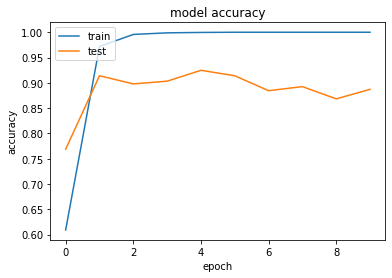

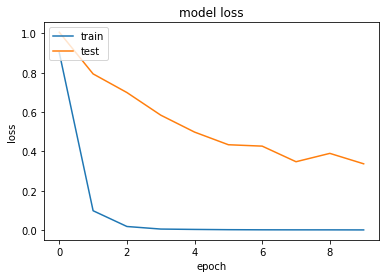

In [29]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model is giving a great Validation accuracy around 85+%

Saving Model

In [30]:
model.save('rockpaper_model.h5')